In [1]:
import glob
import json
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
def mode2name(mode):
    if mode == 1:
        return "Background Color"
    elif mode == 2:
        return "Letter"
    elif mode == 3:
        return "Object Color"

In [3]:
test = False
if test:
    base_location = '/media/gregory/HDD/CounterVision/Test/'
    modes = [1, 2]
    n_array = [10000, 15000]
    p_array = [0.95]
    trial_array = [0, 1]
else:
    base_location = '/media/gregory/HDD/CounterVision/SyntheticImages'
    modes = [1,2,3]
    n_array = [5000, 10000, 15000, 20000]
    p_array = [0.5, 0.8, 0.85, 0.9, 0.95, 1.0]
    trial_array = [0,1,2,3,4]
    
def compare(model_new, model_ref):

    out = []
    for mode in modes:
        for n in n_array:
            for p in p_array:
                
                train_new = 0
                neutral_new = 0
                count_new = 0
                
                train_ref = 0
                neutral_ref = 0
                count_ref = 0
                
                for trial in trial_array:

                    save_location = '{}/mode={}/n={}/p={}/trial{}/'.format(base_location, mode, n, p, trial)
                    os.chdir(save_location)

                    for file in glob.glob('*.json'):
                        data = json.load(open(file, 'r'))
                        
                        if file == model_new:
                            train_new += data['train']
                            neutral_new += data['neutral']
                            count_new += 1
                        elif file == model_ref:
                            train_ref += data['train']
                            neutral_ref += data['neutral']
                            count_ref += 1
                            
                train_new /= max(count_new, 1)
                neutral_new /= max(count_new, 1)
                
                train_ref /= max(count_ref, 1)
                neutral_ref /= max(count_ref, 1)

                out.append([mode, n, p, train_new, neutral_new, train_ref, neutral_ref])
                
    df = pd.DataFrame(out, columns = ['mode', 'n', 'p', 'train_new', 'neutral_new', 'train_ref', 'neutral_ref'])    
    
    for label_outer, df_outer in df.groupby('mode'):

        fig = plt.figure(figsize=(15, 10))
        fig.subplots_adjust(hspace=0.2, wspace=0.2)

        fig.suptitle('Test Accuracy Comparison: {}'.format(mode2name(label_outer)))
        
        plt.subplot(2, 3, 1)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['train_ref'], label = label)
        plt.title(model_ref)
        plt.xlabel('n')
        plt.ylim(0,1)
        plt.ylabel('Accuracy - Training Distribution')
        plt.legend(title = 'p')

        
        plt.subplot(2, 3, 2)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['train_new'], label = label)
        plt.title(model_new)
        plt.xlabel('n')
        plt.ylim(0,1)
        
        plt.subplot(2, 3, 3)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['train_new'] - df['train_ref'], label = label)
        plt.title('change')
        plt.xlabel('n')
        
        plt.subplot(2, 3, 4)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['neutral_ref'], label = label)
        plt.xlabel('n')
        plt.ylabel('Accuracy - Neutral Distribution')
        plt.ylim(0,1)
        
        plt.subplot(2, 3, 5)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['neutral_new'], label = label)
        plt.xlabel('n')
        plt.ylim(0,1)
        
        plt.subplot(2, 3, 6)
        for label, df in df_outer.groupby('p'):
            plt.plot(df['n'], df['neutral_new'] - df['neutral_ref'], label = label)
        plt.xlabel('n')

        plt.show()
        plt.close()
                    
                            

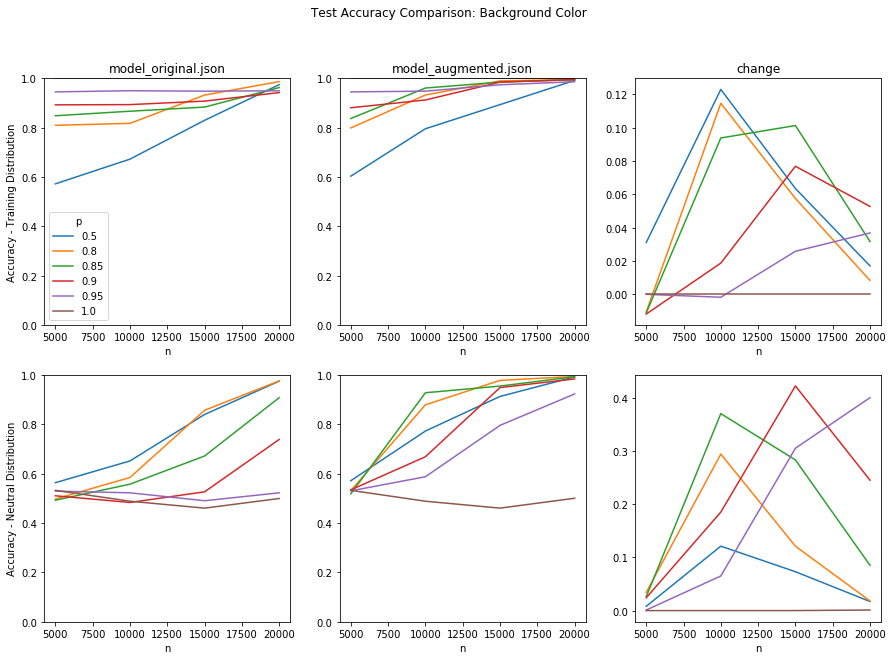

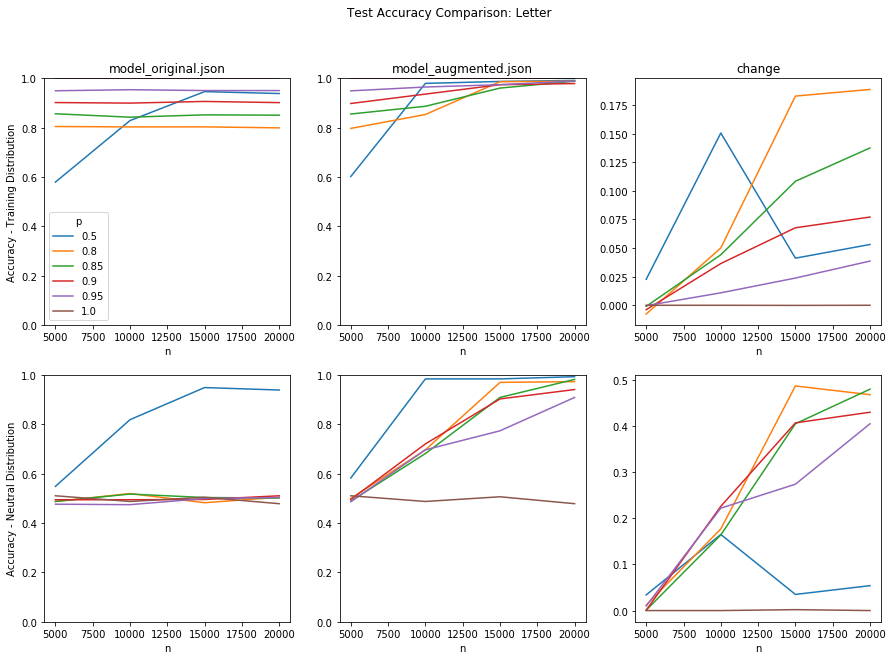

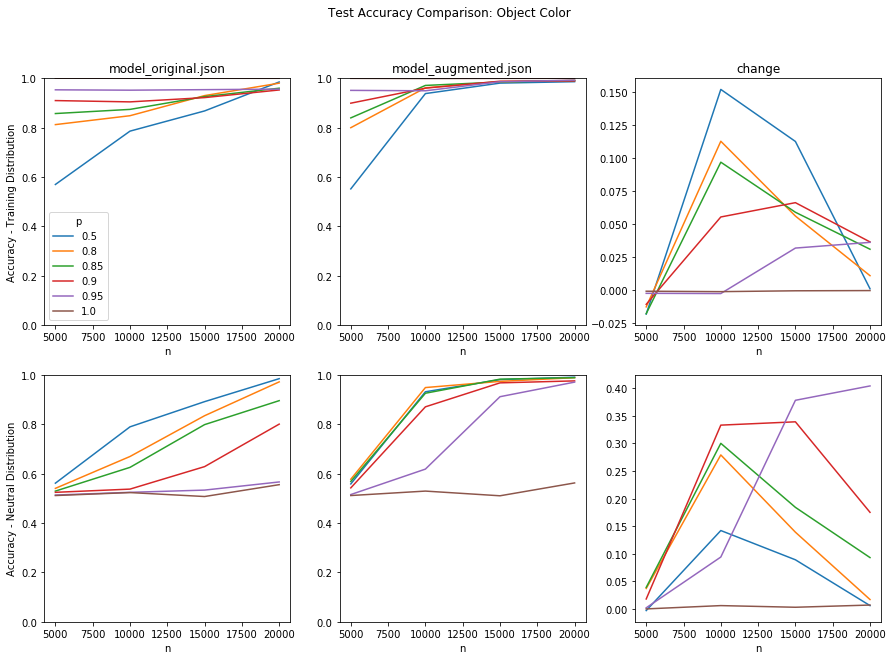

In [4]:
compare('model_augmented.json', 'model_original.json')


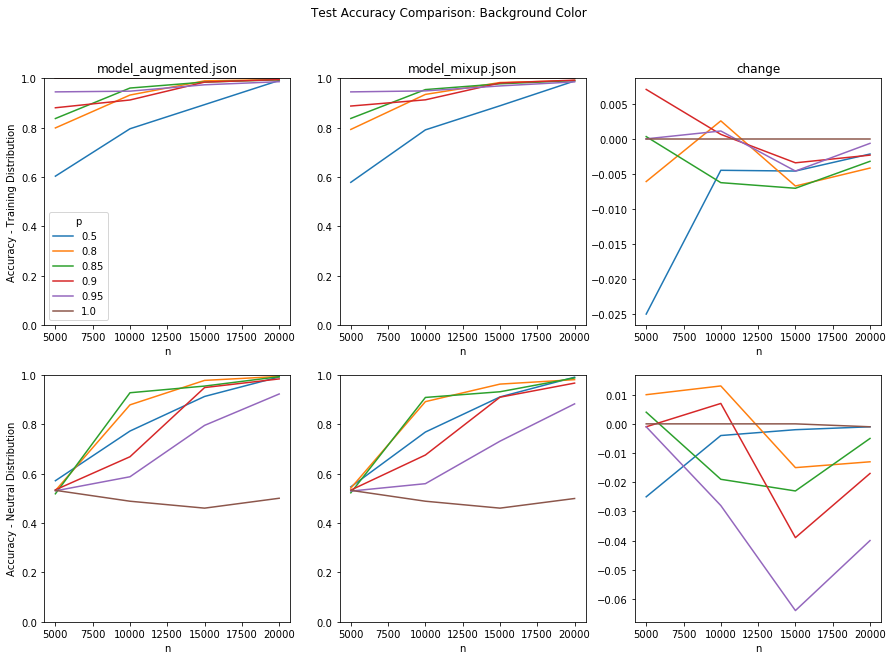

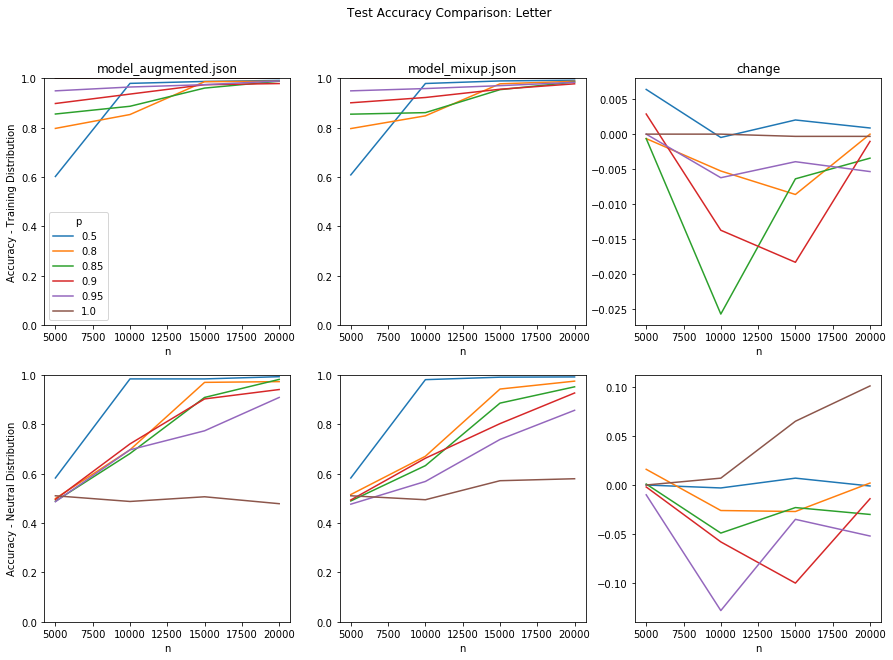

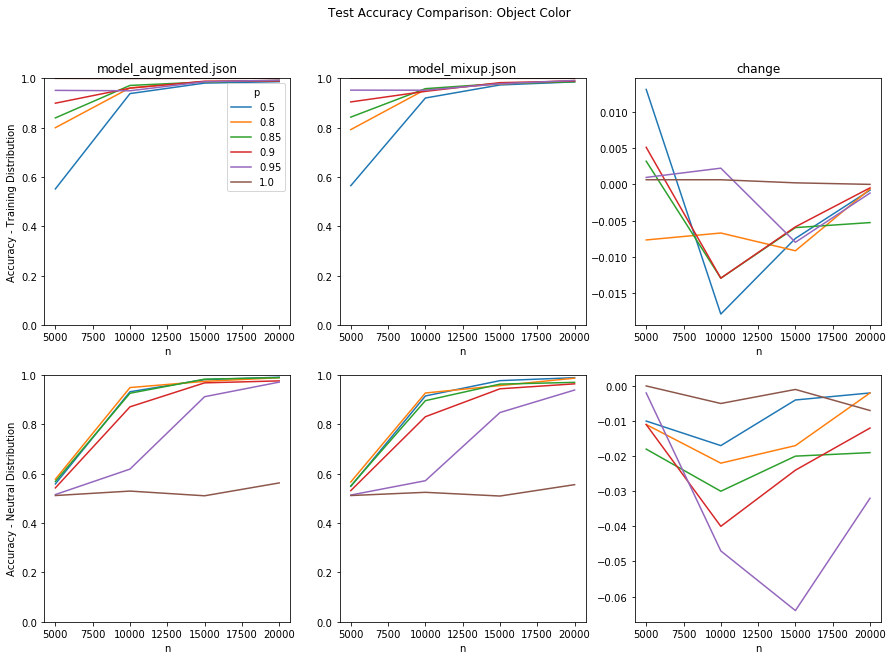

In [5]:
compare('model_mixup.json', 'model_augmented.json')